# CRAFTY Web Scraping. Flavio Romano, 614801

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

"""Datasets"""
transactions = pd.read_csv("./datasets/transactions.csv", names=["timestamp", "blockId", "txId", "isCoinbase", "fee"])
inputs = pd.read_csv("./datasets/inputs.csv", names=["txId", "prevTxId", "prevTxPos"])
outputs = pd.read_csv("./datasets/outputs.csv", names=["txId", "position", "addressID", "amount", "scriptType"])
mapping_df = pd.read_csv("./datasets/mapAddr2Ids8708820.csv", names=["hash", "addressID"])

transactions['timestamp'] = pd.to_datetime(transactions['timestamp'], unit='s')

### Analisi generali sui dati

In [3]:
print(transactions.head())
print(inputs.head())
print(outputs.head())
print(mapping_df.head())

            timestamp  blockId  txId  isCoinbase  fee
0 2009-01-09 03:54:39        9     9           1    0
1 2009-01-11 01:00:54       78    78           1    0
2 2009-01-12 03:30:25      170   171           0    0
3 2009-01-12 06:02:13      181   183           0    0
4 2009-01-12 06:12:16      182   185           0    0
   txId  prevTxId  prevTxPos
0   171         9          0
1   183       171          1
2   185       183          1
3   187       185          1
4   192       187          0
   txId  position  addressID      amount  scriptType
0     9         0          9  5000000000           1
1    78         0         78  5000000000           1
2   171         0        171  1000000000           1
3   171         1          9  4000000000           1
4   183         0        183  1000000000           1
                                 hash  addressID
0  1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa          0
1  12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX          1
2  1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1

### Distribuzione del numero di transazioni per blocco (occupazione del blocco), nell’intero periodo temporale considerato

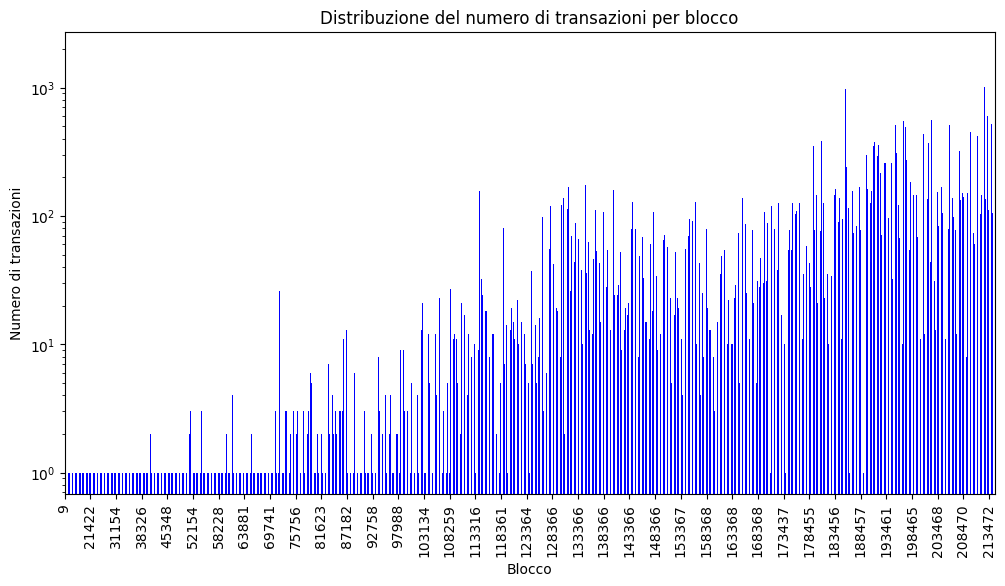

In [24]:
transactions_per_block = transactions.groupby("blockId")["txId"].count()

plt.figure(figsize=(12,6))
transactions_per_block.plot(kind="bar", color="blue")
plt.xlabel("Blocco")
plt.ylabel("Numero di transazioni")
plt.title("Distribuzione del numero di transazioni per blocco")

plt.yscale("log")

x_ticks = range(0, len(transactions_per_block), 5000)
plt.xticks(x_ticks, transactions_per_block.index[x_ticks])

plt.show()

### Evoluzione dell'occupazione dei blocchi nel tempo

01-01-09


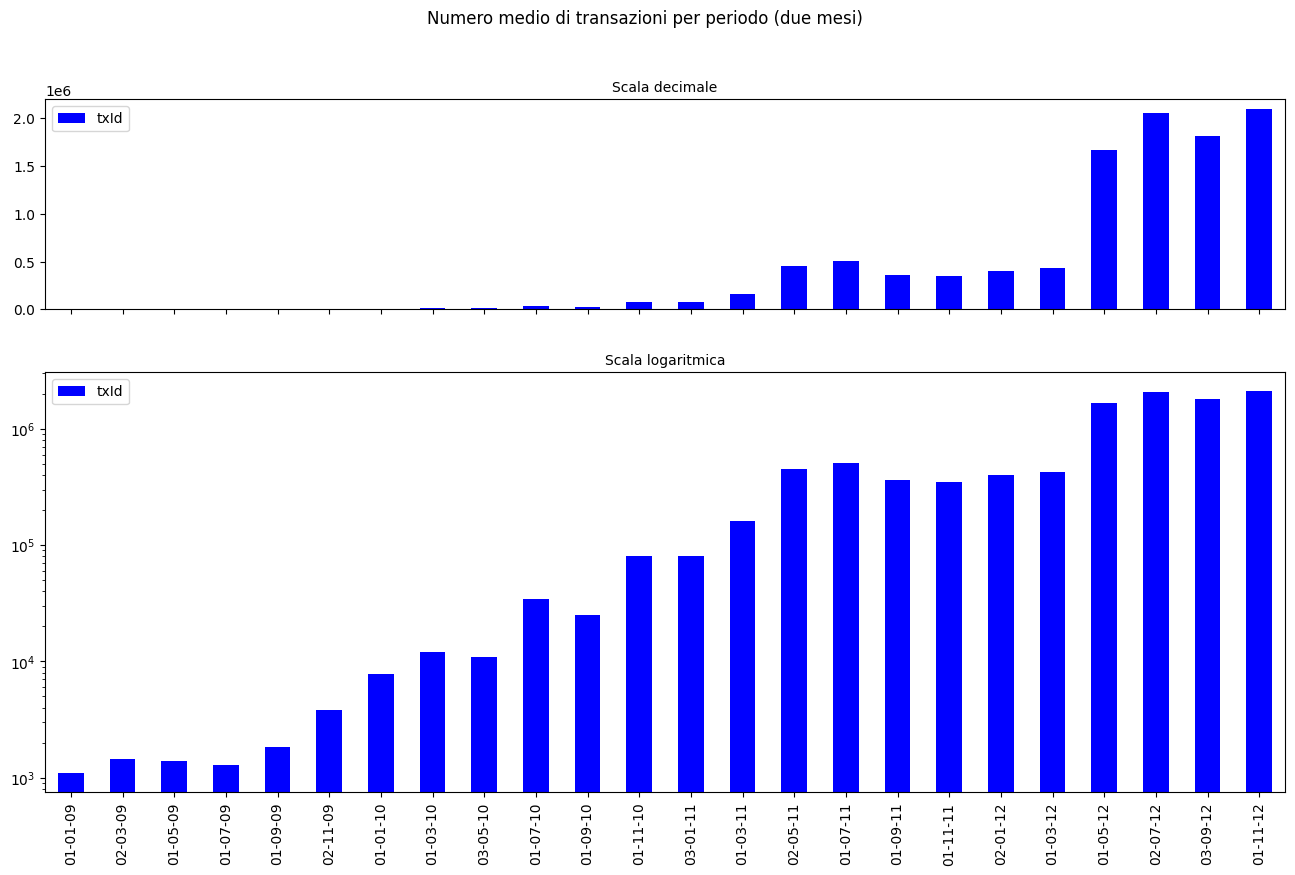

In [59]:
avg_transactions_per_period = transactions[["timestamp", 'txId']].resample(
    '2BMS', on="timestamp").count()

avg_transactions_per_period.index = [date.strftime("%d-%m-%y") for date in avg_transactions_per_period.index]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(
    16, 9), gridspec_kw={'height_ratios': [1, 2]})
fig.suptitle("Numero medio di transazioni per periodo (due mesi)")
avg_transactions_per_period.plot(ax=axes[0], kind="bar", color="blue")
axes[0].set_title("Scala decimale", fontsize=10)

print(avg_transactions_per_period.index[0])

avg_transactions_per_period.plot(ax=axes[1], kind="bar", color="blue")
axes[1].set_title("Scala logaritmica", fontsize=10)
plt.yscale("log")

plt.show()

#### Ammontare totale degli UTXO al momento dell’ultima transazione

In [110]:
temp = outputs.merge(inputs, how='inner', left_on=["txId", "position"], right_on=["prevTxId", "prevTxPos"])
utxo = outputs.amount.sum() - temp.amount.sum()
print(utxo)  #  859303372614879

859303372614879


#### Distribuzione degli intervalli di tempo che intercorrono tra la transazione che genera un valore in output e quella che lo consuma

           timestamp_created     timestamp_spent  timestamp_difference
0        2009-01-09 03:54:39 2009-01-12 03:30:25                     2
1        2009-01-12 03:30:25 2009-01-12 06:02:13                     0
2        2009-01-12 06:02:13 2009-01-12 06:12:16                     0
3        2009-01-12 06:12:16 2009-01-12 06:34:22                     0
4        2009-01-12 06:34:22 2009-01-12 07:16:40                     0
...                      ...                 ...                   ...
21378765 2012-12-31 23:52:37 2012-12-31 23:52:37                     0
21378766 2012-12-31 23:52:37 2012-12-31 23:52:37                     0
21378767 2012-12-31 23:52:37 2012-12-31 23:52:37                     0
21378768 2012-12-31 23:52:37 2012-12-31 23:52:37                     0
21378769 2012-12-31 20:50:15 2012-12-31 23:52:37                     0

[21312091 rows x 3 columns]


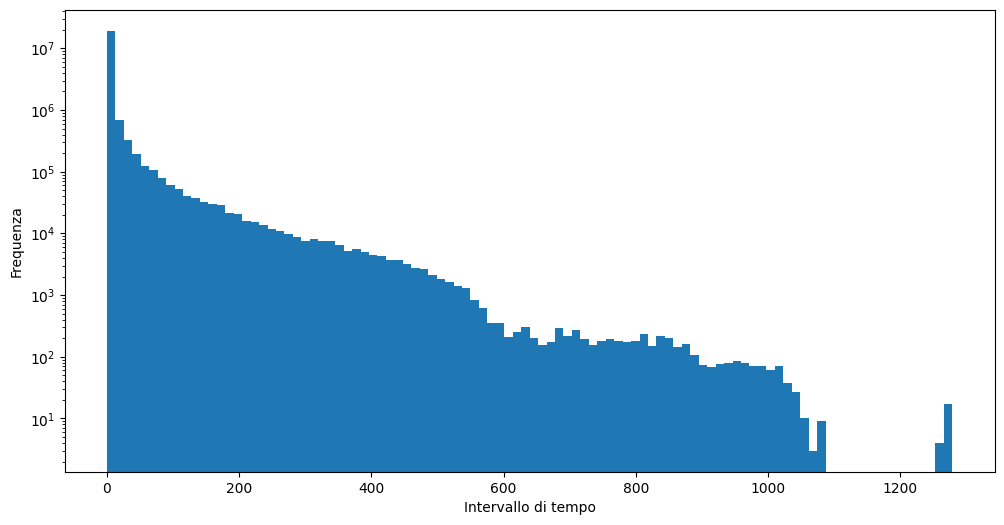

In [40]:
spent = transactions.merge(inputs, on="txId").rename(columns={"timestamp": "timestamp_spent"})[["timestamp_spent", "txId", "prevTxId", "prevTxPos"]]
created = transactions.merge(outputs, on="txId").rename(columns={"timestamp": "timestamp_created"})[["timestamp_created", "txId", "position"]]

diff = spent.merge(created.rename(columns={"txId": "outTxId"}), how="inner", left_on=["prevTxId", "prevTxPos"], right_on=["outTxId", "position"])[["timestamp_created", "timestamp_spent"]]
diff["timestamp_difference"] = (diff.timestamp_spent - diff.timestamp_created).dt.days
diff.drop(diff[diff.timestamp_difference < 0].index, inplace=True) # rimuovo inconsistenze

plt.figure(figsize=(12, 6))
plt.hist(diff[["timestamp_difference"]], bins=100)
plt.yscale("log")
plt.xlabel("Intervallo di tempo")
plt.ylabel("Frequenza")
plt.show()